In [1]:
## if you are using google colab, you can mount your google drive to save/load the model
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#%unzip large_ds.zip
ds_folder = 'load'

In [3]:
## install the required packages, commented to avoid timeconsuming checking
'''%pip install peft
%pip install transformers
%pip install torch >2.0 torchvision #torchaudio
%pip install monai
%pip install pillow
%pip install matplotlib
%pip install torchmetrics
%pip install tensorboardX
%pip install tensorboard'''


'%pip install peft\n%pip install transformers\n%pip install torch >2.0 torchvision #torchaudio\n%pip install monai\n%pip install pillow\n%pip install matplotlib\n%pip install torchmetrics\n%pip install tensorboardX\n%pip install tensorboard'

In [4]:
import torch
from peft import LoraConfig, get_peft_model
import transformers
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import monai
import matplotlib.pyplot as plt
import metric
import writer

/Users/michael/miniconda3/envs/fortiss/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def check_mask_size(datapoint):
  m_width, m_height = datapoint['mask'].size
  if m_width != 256 or m_height != 256:
    return False
  i_width, i_height = datapoint['image'].size
  if i_width != 256 or i_height != 256:
    return False
  return True

In [9]:
def create_dataset(load_path, set_type):
    dataset = []
    cnt = 0
    for filename in os.listdir(f'{load_path}/img/{set_type}'):
            if filename.endswith('.png'):
                datapoint = {}
                datapoint['image'] = Image.open(f'{load_path}/img/{set_type}/{filename}')
                datapoint['mask'] = Image.open(f'{load_path}/masks/{set_type}/{filename}')
                datapoint['filename'] = filename
                if check_mask_size(datapoint):
                  dataset.append(datapoint)
                else:
                  cnt += 1
    print(cnt)
    return dataset

In [10]:
train_data = create_dataset(ds_folder, 'train')
eval_data = create_dataset(ds_folder, 'eval')
test_data = create_dataset(ds_folder, 'test')
print(len(train_data), len(eval_data), len(test_data))

335
20
50
3342 196 383


In [11]:
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["mask"])

    # prepare image and prompt for the model
    inputs = self.processor(image, return_tensors="pt") #input_boxes=[[prompt]]

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    # add labels
    inputs["labels"] = ground_truth_mask

    return inputs

In [12]:
processor = transformers.SamProcessor.from_pretrained("facebook/sam-vit-base")

In [13]:
train_dataset = SAMDataset(dataset=train_data, processor=processor)
eval_dataset = SAMDataset(dataset=eval_data, processor=processor)
test_dataset = SAMDataset(dataset=test_data, processor=processor)

In [14]:
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(device)

# subclass trainer source: https://medium.com/deeplearningmadeeasy/how-to-use-a-custom-loss-with-hugging-face-fc9a1f91b39b
class CustomTrainer(transformers.Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        #print(inputs.keys())
        outputs = model(**inputs, multimask_output=False) #multimask_output=False
        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = inputs["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        return (loss, outputs) if return_outputs else loss
    
    def predict(self, test_dataset):
        predictions, labels, metrics = super().predict(test_dataset)
        return predictions, labels, metrics

mps


In [15]:
model = transformers.SamModel.from_pretrained("epochs5_large_dsLoRa/saved")

In [16]:
args = transformers.TrainingArguments(
    output_dir="output",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=1e-3,
    remove_unused_columns=False,
    logging_steps = 100,
    save_strategy='epoch',
    label_names=["labels"],
)

trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=transformers.default_data_collator,
)

In [19]:
predictions, labels, metrics = trainer.predict(test_dataset)

python(63713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 383/383 [27:00<00:00,  4.23s/it]


In [20]:
print(len(predictions))
print(predictions[0].shape)
print(predictions[1].shape)

2
(383, 1, 1)
(383, 1, 1, 256, 256)


In [21]:
print(predictions[0])

[[[0.8085789 ]]

 [[0.61020154]]

 [[0.7381119 ]]

 [[0.79675055]]

 [[0.7105357 ]]

 [[0.420857  ]]

 [[0.7434113 ]]

 [[0.7035495 ]]

 [[0.70178515]]

 [[0.665118  ]]

 [[0.72675127]]

 [[0.3004231 ]]

 [[0.7387679 ]]

 [[0.73414797]]

 [[0.7955234 ]]

 [[0.47773272]]

 [[0.831821  ]]

 [[0.68940425]]

 [[0.4762064 ]]

 [[0.7244681 ]]

 [[0.6731955 ]]

 [[0.6354422 ]]

 [[0.61888003]]

 [[0.6158558 ]]

 [[0.8105792 ]]

 [[0.8063799 ]]

 [[0.78803575]]

 [[0.72221637]]

 [[0.62644553]]

 [[0.7714505 ]]

 [[0.6554785 ]]

 [[0.63533205]]

 [[0.43496728]]

 [[0.8734988 ]]

 [[0.6573683 ]]

 [[0.84053886]]

 [[0.8313346 ]]

 [[0.6182473 ]]

 [[0.7953047 ]]

 [[0.8294526 ]]

 [[0.68778664]]

 [[0.6499113 ]]

 [[0.6702869 ]]

 [[0.74754757]]

 [[0.8320223 ]]

 [[0.5792881 ]]

 [[0.7221266 ]]

 [[0.6164602 ]]

 [[0.7272278 ]]

 [[0.63292795]]

 [[0.64444137]]

 [[0.63398075]]

 [[0.5280411 ]]

 [[0.80877006]]

 [[0.82667464]]

 [[0.73425597]]

 [[0.7482042 ]]

 [[0.68346024]]

 [[0.6924717 ]

(383, 256, 256)


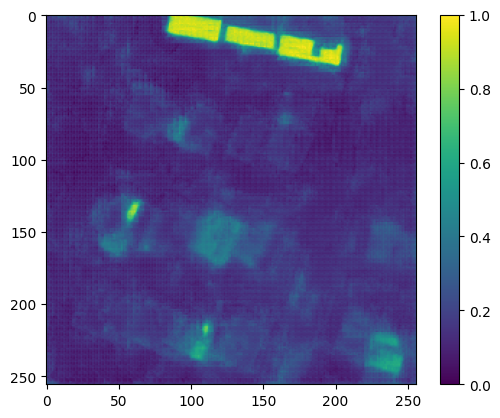

In [33]:
prediction_0 = predictions[1].squeeze()
print(prediction_0.shape)
pred = list(prediction_0)
pred_1 = normalize_array(pred[0])
plt.imshow(pred_1)
plt.colorbar()
plt.show()

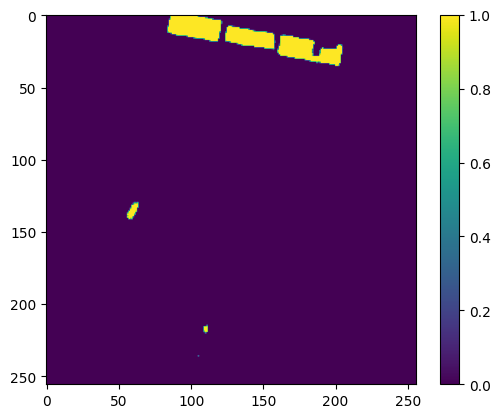

In [34]:
pred = list(prediction_0)
pred_1 = pred[0].clip(0, 1)
plt.imshow(pred_1)
plt.colorbar()
plt.show()

(383, 256, 256)


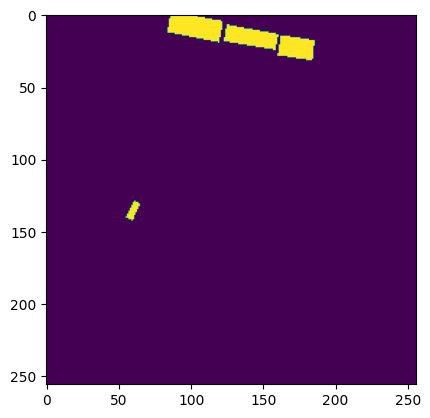

In [36]:
print(labels.shape)
plt.imshow(labels[0])
plt.show()

In [32]:
def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

(383, 1, 1, 256, 256)


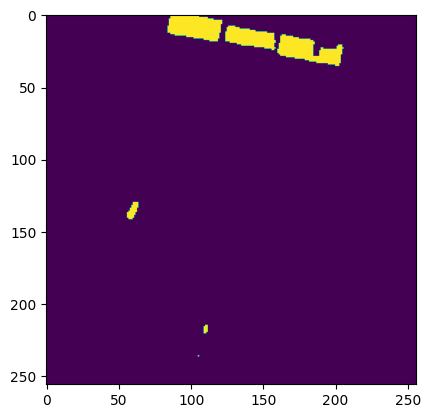

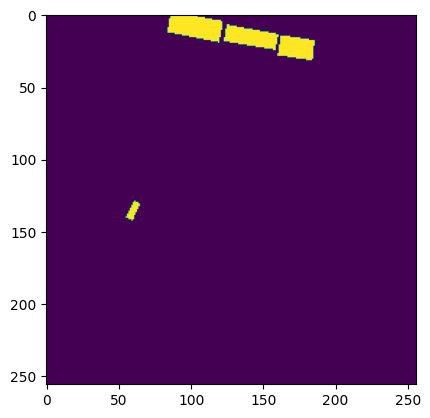

/Users/michael/miniconda3/envs/fortiss/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered `nan` values in tensor. Will be removed.
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/michael/miniconda3/envs/fortiss/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


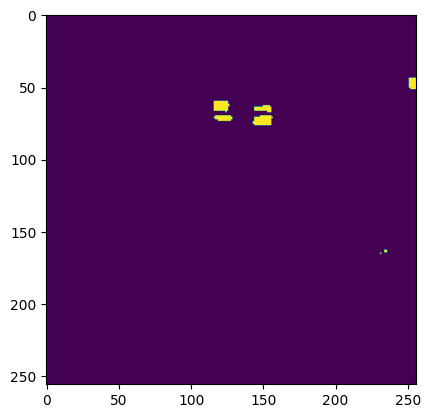

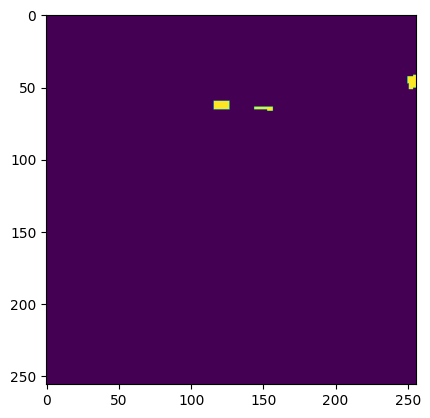

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


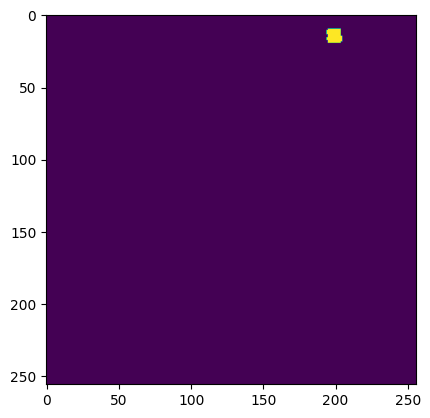

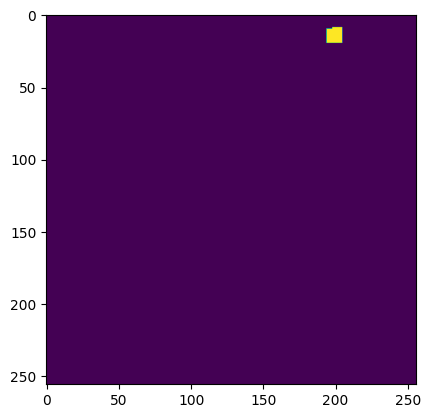

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


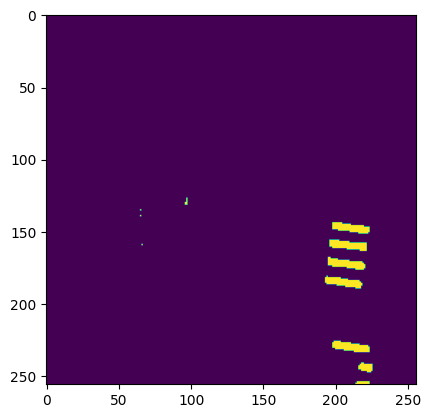

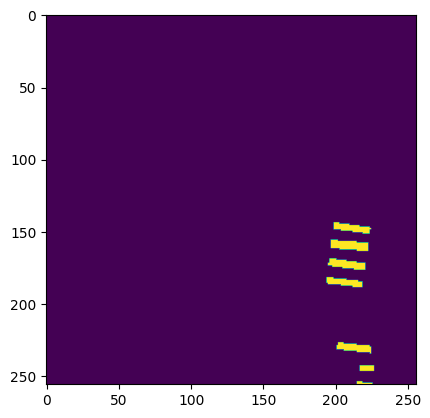

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


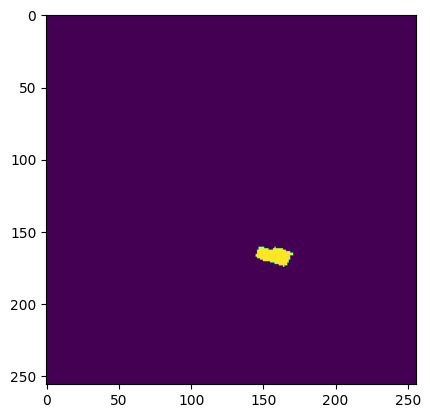

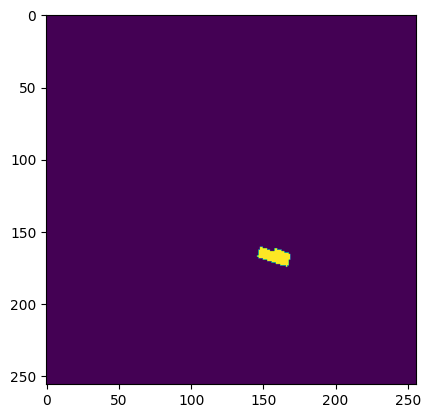

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


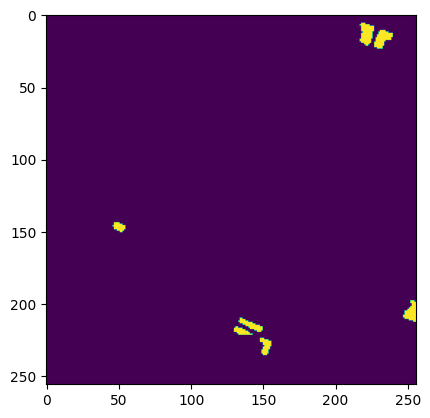

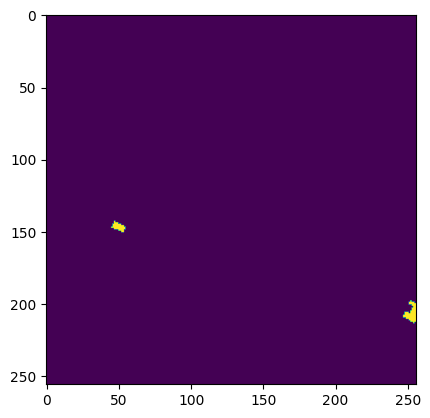

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


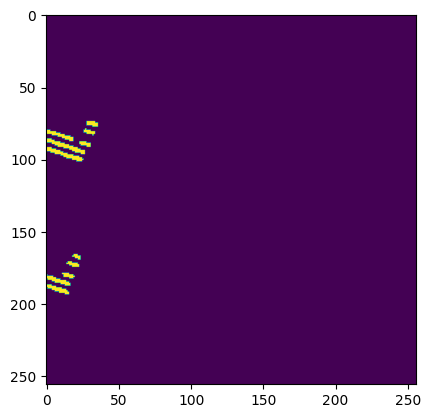

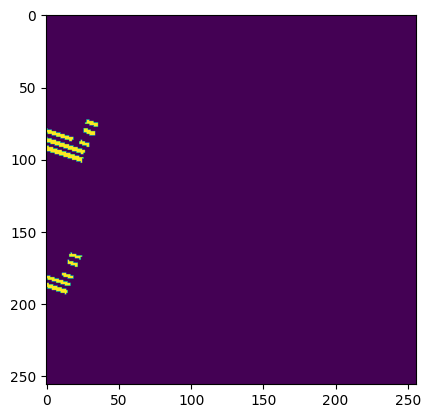

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


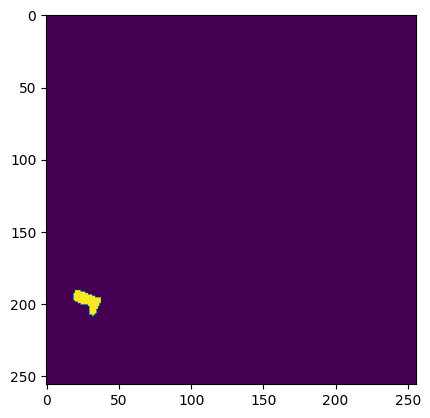

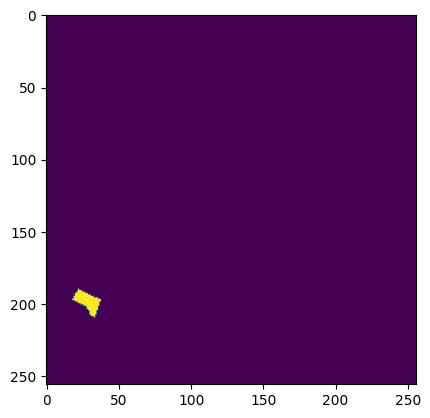

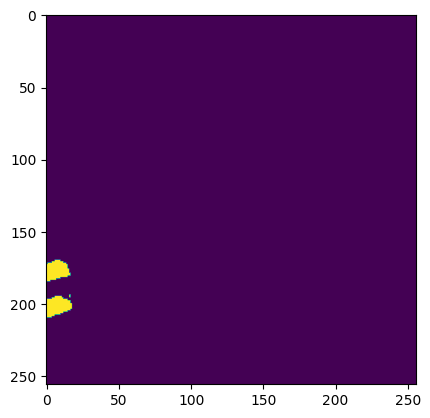

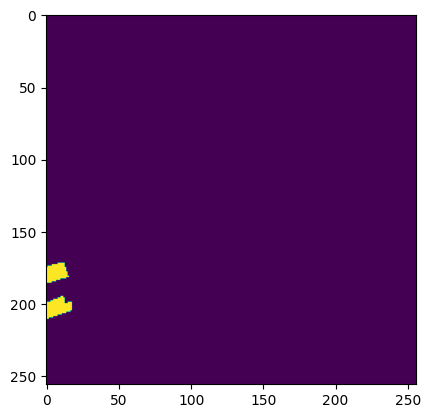

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


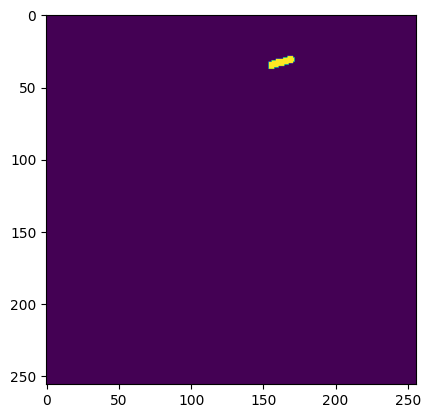

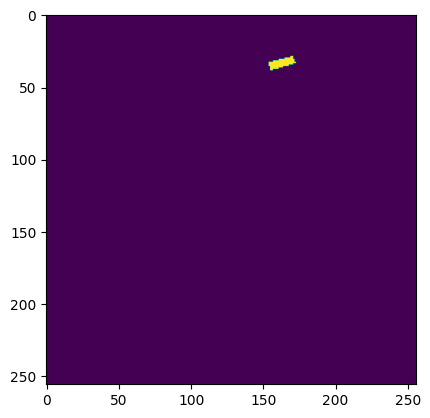

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


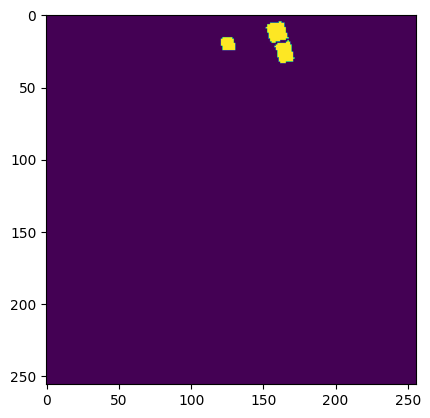

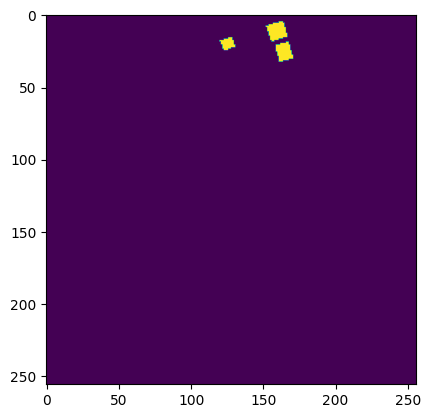

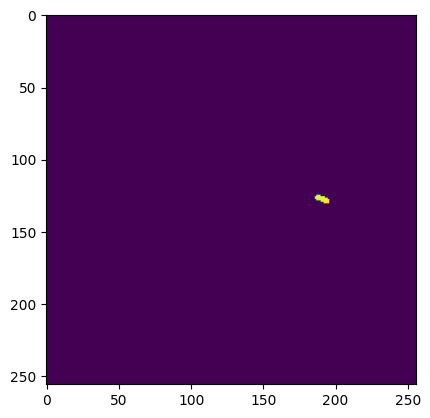

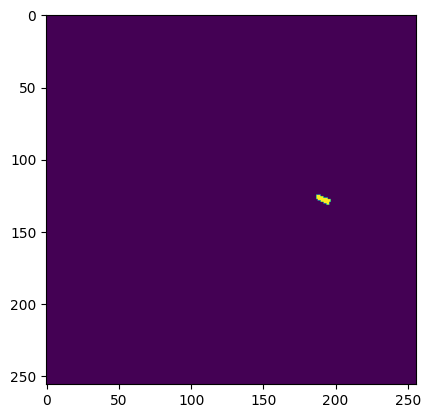

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


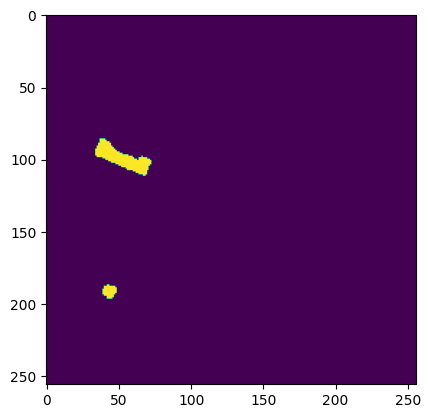

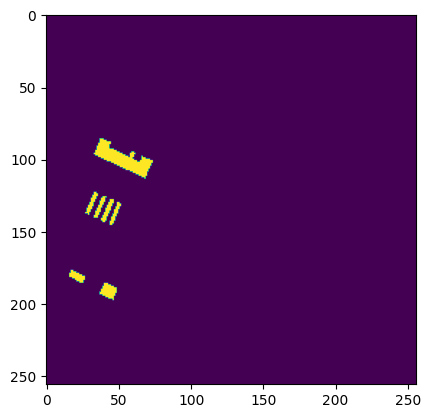

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


In [25]:
outpath = 'test'

metrics = metric.Metrics(['JaccardIndex', 'DiceCoefficient', 'Precision', 'Recall', 'Accuracy', 'F1Score', 'AUCROC'], device="cpu")
m_writer = writer.Writer(os.path.join(outpath, 'test'))


predict = predictions[1]
print(predict.shape)
predict = predict.squeeze()
preds = list(predict)
for i, prediction in enumerate(preds):
  prediction = prediction > 0.01
  prediction = prediction.astype(int)

  gt_np = labels[i]

  metrics.reset_current()
  pred = torch.from_numpy(prediction)
  gt = torch.from_numpy(gt_np)
  metrics.update(pred, gt)
  values = metrics.compute()
  
  m_writer.write_metrics_and_means(values, i)
  m_writer.write_pr_curve(prediction,gt, i)
  #m_writer.write_gt_vs_pred_figure(prediction, gt, i, "Gt vs Pred")

  if i%50 == 0: # print every 50th image

    plt.imshow(prediction)
    plt.show()

    plt.imshow(gt_np)
    plt.show()